In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from rdkit.Chem import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganGenerator
morgan = GetMorganGenerator(radius=2)
fingerprinter = lambda smiles : np.stack([morgan.GetFingerprintAsNumPy(MolFromSmiles(smile)) for smile in smiles])

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

%load_ext autoreload
%autoreload 2

## Data

In [2]:
train = pd.read_csv('../data/log_normalized/train.csv')
validation = pd.read_csv('../data/log_normalized/validation.csv')
test = pd.read_csv('../data/log_normalized/test.csv')
properties = train.columns[1:]

In [3]:
train_X = fingerprinter(train['SMILES'].tolist())
validation_X = fingerprinter(validation['SMILES'].tolist())
test_X = fingerprinter(test['SMILES'].tolist())

n_features = train_X.shape[1]
print(f'Fingerprints have {n_features} features')

Fingerprints have 2048 features


## Train

In [4]:
with open('./hyperparameters/optimized_multi/xgbr.json') as f:
    hyperparameters = json.load(f)

In [5]:
multi_xgbr = MultiOutputRegressor(
    XGBRegressor(**hyperparameters)
)
multi_xgbr.fit(train_X, train.iloc[:, 1:])
print(f'Score: {multi_xgbr.score(test_X, test.iloc[:, 1:])}')

Score: -0.09828304108166681


## Test

In [6]:
test_predictions = pd.DataFrame(multi_xgbr.predict(test_X))
test_predictions.columns = test.columns[1:]
#test_predictions.to_csv('./predictions/xgbr/validation.csv', index=False)

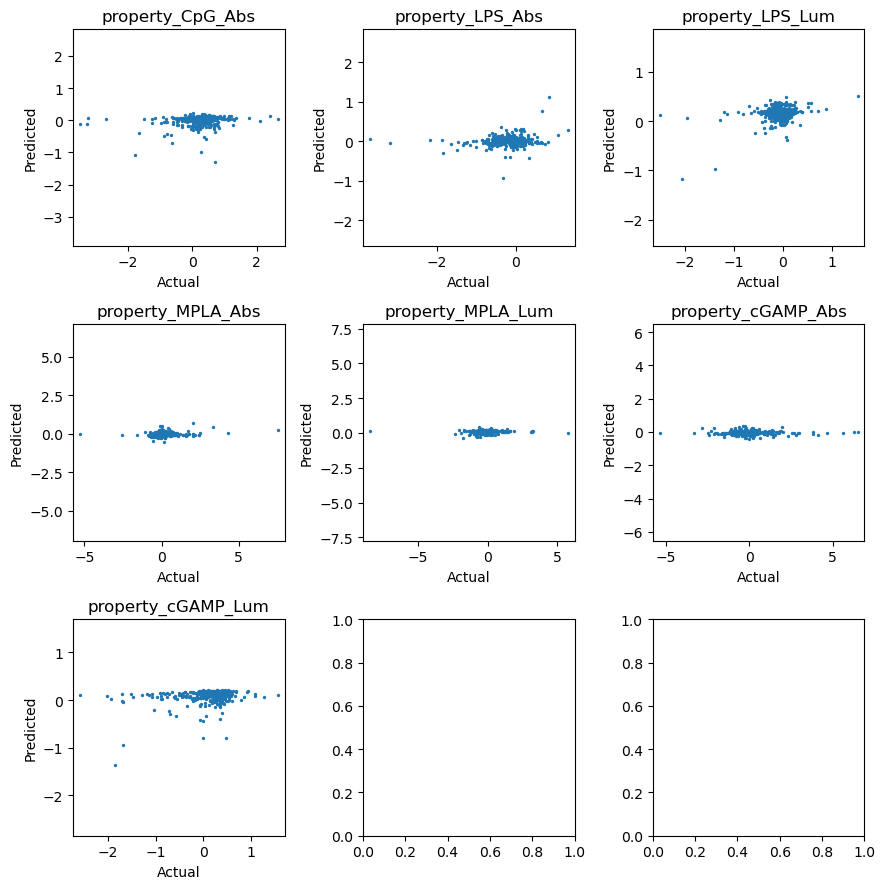

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.flatten()

for i, property_label in enumerate(properties):

    ax = axs[i]

    ax.scatter(test.iloc[:, i+1], test_predictions.iloc[:, i], s=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(property_label)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()

In [8]:
#fig.savefig('./figures/predictions.pdf')